# EDA: CancerModels.Org Data Assessment

In [1]:
import pandas as pd
from tqdm import tqdm
from utils import read_metadata_without_fields, get_files, get_dirs, read_metadata_with_fields
from pandas import read_csv, DataFrame, concat
from os.path import join, dirname, exists
from time import ctime, time
from subprocess import run, check_output, CalledProcessError
import seaborn as sns
import logging


logging.basicConfig(filename='{}.log'.format('data_overview_file_generation'), filemode='a+', level=logging.DEBUG)

In [2]:
def get_git_tags():
    try:
        tags = check_output([f'cd {home}; git tag'], shell=True, text=True).splitlines()
        return [t for t in tags if t.__contains__('PDCM')]
    except CalledProcessError as e:
        print("Error:", e)
        return None

def checkout_and_run_function(tag, git_tags):
    try:
        logging.info(f"{ctime()}: Running pipeline for tag: {tag}")
        run([f'cd {home}; git checkout {tag}'], shell=True, check=True)
        mol_data, total_models, phenomics_dp, provider_country_df = get_mol_data(home, git_tags[tag])
        phenomics_dp.to_csv(f"phenomics_data_points_{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
        provider_country_df.to_csv(f"provider_country_{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
        mol_data.to_csv(f"{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
        total_models.to_csv(f"total_models_{str(git_tags[tag]).replace('PDCM_', '')}.csv", index=False)
    except CalledProcessError as e:
        print("Error:", e)

In [3]:
home = "/Users/tushar/CancerModels/pdxfinder-data/data/UPDOG"
data_types = ['mut', 'cna', 'expression', 'immunemarker', 'biomarker', 'images', 'cyto']
usa = "United States of America"
provider_country = {"BROD": usa, "DFCI-CPDM": usa, "MDAnderson-CCH": usa, "UOC-BC": "United Kingdom", "CCIA": "Australia", "GCCRI": usa, "NKI": "Netherlands", "UOM-BC": "United Kingdom", "CHOP": usa, "HCI-BCM": usa, "PDMR": usa, "VHIO-BC": "Spain", "CMP": "United Kingdom", "HKU": "Hong Kong", "PMLB": "Canada", "VHIO-CRC": "Spain", "CRL": usa, "IRCC-CRC": "Italy", "PMLB-Organoid": "Canada", "VHIO-PC": "Spain", "CSHL": usa, "IRCC-GC": "Italy", "SANG": "United Kingdom", "WCMC": usa, "CUIMC": usa, "JAX": usa, "SJCRH": usa, "WUSTL": usa, "Curie-BC": "France", "LIH": "Luxembourg", "TRACE": "Belgium", "Wistar-MDAnderson-Penn": usa, "Curie-LC": "France", "LurieChildrens": usa, "UCD": usa, "Curie-OC": "France", "MDAnderson": usa, "UMCG": "Netherlands", "UMCU": "Netherlands", "HCMI": usa, "PPTC": usa, "PIVOT": usa, 'CDH': 'Singapore', 'IDI-IRCCS': 'Italy', 'IRCCS-DEB': "Italy", 'IRCCS-HSM-GE': 'Italy', 'IRCCS-ICH': "Italy", 'IRCCS-IOR': 'Italy', 'IRCCS-IRE': "Italy", 'IRCCS-IRFMN': 'Italy', 'IRCCS-IRST': "Italy", 'IRCCS-ITGPII': 'Italy', 'IRCCS-OPBG': "Italy", 'IRCCS-PAS': "Italy"}

## EDA 1: Data overview
- Percentage of models that have data based on the data types
- Data types based on the protocol used
- Data types based on the technology (Platform used)

In [4]:
def get_mol_data(home, release):
    cm_providers = sorted(get_dirs(home))
    mol_data = DataFrame()
    total_model = DataFrame()
    phenomics_dp = DataFrame()
    provider_country_df = DataFrame()
    
    for pro_num in tqdm(range(len(cm_providers)), "Generating data for analysis"):
        phenomics_mol_data_dp = DataFrame()
        pmd = DataFrame()
        provider = cm_providers[pro_num]
        provider_country_df = pd.concat([provider_country_df, DataFrame([[release, provider, provider_country[provider]]])])
        logging.info(f"{ctime()}: Processing: {provider}")
        provider_path = join(home, provider)
        if not exists(join(provider_path, f'{provider}_metadata-patient_sample.tsv')):
            logging.info(f"{ctime()}: {provider}: Patient sample missing.")
            continue
        if not (exists(join(provider_path, f'{provider}_metadata-pdx_model.tsv')) or 
                exists(join(provider_path, f'{provider}_metadata-cell_model.tsv'))):
            logging.info(f"{ctime()}: {provider}: Model sheet missing.")
            continue
        start = time()
        provider_mol_data = DataFrame()
        provider_data_types = get_dirs(provider_path)
        model = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-patient_sample.tsv'))
        patient = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-patient.tsv'))[['patient_id', 'sex', 'ethnicity']]
        patient['patient_id'] = patient['patient_id'].astype(str)
        model['patient_id'] = model['patient_id'].astype(str)
        model = model.merge(patient, on ='patient_id', how='left')
        model_temp = DataFrame()
        if exists(join(provider_path, f'{provider}_metadata-pdx_model.tsv')):
            pdx = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-pdx_model.tsv'))[['model_id', 'publications']]
            pdx['model_type'] = 'PDX'
            model_temp = pd.concat([model_temp, pdx[['model_id', 'model_type', 'publications']]])
        if exists(join(provider_path, f'{provider}_metadata-cell_model.tsv')): 
            cell = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-cell_model.tsv'))[['model_id', 'type', 'publications']]
            cell['model_type'] = cell['type']
            model_temp = pd.concat([model_temp, cell[['model_id', 'model_type', 'publications']]]) 
        model = model.merge(model_temp, on='model_id', how='left')
        model['provider'] = provider
        model = model.drop_duplicates(['model_id'])
        total_model = concat([total_model, model[['model_id', 'provider', 'model_type', 'publications', 'age_in_years_at_collection', 'diagnosis', 'tumour_type', 'primary_site', 'sex', 'ethnicity']]]).reset_index(drop=True)
        for data_type in data_types:
            if data_type in provider_data_types:
                data_path = join(provider_path, data_type)
                files = [f for f in get_files(data_path) if f.endswith('.tsv')]
                if len(files)==0:
                    dirs = get_dirs(data_path)
                    files = list()
                    for dir in dirs:
                        f = get_files(join(data_path, dir))
                        f = [join(dir, i) for i in f if i.endswith('.tsv')]
                        files.append(f)
                    files = [item for sublist in files for item in sublist]
                for file_name in files:
                    temp = read_csv(join(data_path, file_name), sep='\t', usecols=['sample_id', 'platform_id'])
                    if data_type == 'cyto':
                        data_type = 'biomarker'
                    temp['type'] = data_type
                    temp['provider'] = provider
                    phenomics_mol_data_dp = pd.concat([phenomics_mol_data_dp, DataFrame([['molecular_data_'+data_type, provider, temp.shape[0]]])]).reset_index(drop=True)
                    temp = temp.drop_duplicates()
                    provider_mol_data = concat([provider_mol_data, temp]).reset_index(drop=True) 
        if len(provider_mol_data) > 0:
            platform = read_metadata_without_fields(join(provider_path, f'{provider}_molecular_metadata-platform.tsv'))[['platform_id','molecular_characterisation_type','instrument_model','library_strategy']]
            platform['molecular_characterisation_type'] = platform['molecular_characterisation_type'].str.replace('cytogenetics', 'biomarker') 
            sample = read_metadata_without_fields(join(provider_path, f'{provider}_molecular_metadata-sample.tsv'))
            sample = sample[['platform_id','model_id','sample_id', 'sample_origin']]
            sample['sample_id'] = sample['sample_id'].astype(str) 
            provider_mol_data['sample_id'] = provider_mol_data['sample_id'].astype(str)
            pmd = provider_mol_data.merge(platform, on='platform_id', how='left').merge(sample, on='sample_id', how='left')
            for ind, row in pmd.iterrows():
                model_type = model[model['model_id'] == row['model_id']]['model_type'].reset_index(drop=True)
                if len(model_type) > 0:
                    model_type = model_type[0]
                    if model_type != 'PDX':
                        sample_origin = 'cell'
                    else:
                        sample_origin = 'xenograft'
                    if row['sample_origin'] == '':
                        row['sample_origin'] = sample_origin
            pmd['sample_origin'] = pmd['sample_origin'].str.replace('\s$', '', regex=True).str.lower()
            
            mol_data = concat([mol_data, pmd]).reset_index(drop=True)
            
        if f'{provider}_metadata-model_image.tsv' in get_files(provider_path):
            images = read_metadata_without_fields(join(provider_path, f'{provider}_metadata-model_image.tsv'))
            phenomics_mol_data_dp = pd.concat([phenomics_mol_data_dp, DataFrame([['image_data_points', provider, images.shape[0]]])]).reset_index(drop=True)
            images['provider'] = provider
            images['type'] = 'images'
            images['molecular_characterisation_type'] = 'images'
            images = images[['model_id', 'provider', 'type', 'molecular_characterisation_type']].drop_duplicates()
            for col in mol_data.columns:
                if col not in images.columns:
                    images[col] = ""
            mol_data = concat([mol_data, images]).reset_index(drop=True)
            

        if 'treatment' in get_dirs(provider_path):
            treatment = read_metadata_with_fields(join(provider_path, f'treatment/{provider}_patienttreatment-Sheet1.tsv'))
            phenomics_mol_data_dp = pd.concat([phenomics_mol_data_dp, DataFrame([['treatment_data_points', provider, treatment.shape[0]]])]).reset_index(drop=True)
            treatment = treatment[['patient_id']].drop_duplicates().merge(model.drop_duplicates(['patient_id']), on='patient_id', how='left')
            treatment['provider'] = provider
            treatment['type'] = 'treatment'
            treatment['molecular_characterisation_type'] = 'treatment'
            treatment = treatment[['model_id', 'provider', 'type', 'molecular_characterisation_type', 'sample_id']].drop_duplicates()
            for col in mol_data.columns:
                if col not in treatment.columns:
                    treatment[col] = ""
            mol_data = concat([mol_data, treatment]).reset_index(drop=True)
            

        if 'drug' in get_dirs(provider_path):
            drug = read_metadata_with_fields(join(provider_path, f'drug/{provider}_drugdosing-Sheet1.tsv'))
            phenomics_mol_data_dp = pd.concat([phenomics_mol_data_dp, DataFrame([['drug_data_points', provider, drug.shape[0]]])]).reset_index(drop=True)
            drug = drug.drop_duplicates(['model_id'])
            drug['provider'] = provider
            drug['type'] = 'drug'
            drug['molecular_characterisation_type'] = 'drug'
            drug = drug[['model_id', 'provider', 'type', 'molecular_characterisation_type']].drop_duplicates()
            for col in mol_data.columns:
                if col not in drug.columns:
                    drug[col] = ""
            mol_data = concat([mol_data, drug]).reset_index(drop=True)
            

        if 0 in phenomics_mol_data_dp.columns:            
            phenomics_mol_data_dp = phenomics_mol_data_dp.reset_index(drop=True).groupby(by=0).sum().reset_index().rename({0:'type', 2:'counts'},axis=1)
            total_model_id = phenomics_mol_data_dp['counts'].sum()
            total_row = {'type': 'molecular_data_points_total', 'counts': total_model_id}
            phenomics_mol_data_dp = phenomics_mol_data_dp.append(total_row, ignore_index=True)
        
        total_model.loc[:, 'mt'] = ['Organoid' if str(t).lower().__contains__('organoid') else t for t in total_model['model_type']]
        total_model.loc[:, 'mt'] = ['Cell Line' if str(t).lower().__contains__('cell') or str(t).lower().__contains__('pdc') or str(t).lower().__contains__('2d') or str(t).lower().__contains__('2-d') else t for t in total_model['mt']]
        total_model.loc[:, 'mt'] = ['Other' if str(t).lower().__contains__('other') or str(t).lower().__contains__('mixed') else t for t in total_model['mt']]
        
        df = total_model.groupby('mt').count()['model_id'].reset_index().rename({'mt': 'type', 'model_id': 'counts'}, axis=1)
        total_model_id = df['counts'].sum()
        total_row = {'type': 'model_type_total', 'counts': total_model_id}
        df['type'] = ['model_type_'+f.lower().replace(' ', '_' ) for f in df['type']]
        df = df.append(total_row, ignore_index=True)
        #.str.replace('\s$', '', regex=True)
        if pmd.shape[0]>0:
            pmd_counts = pmd.groupby(by='sample_origin').count()['model_id'].reset_index(name='counts').rename({'sample_origin': 'type'}, axis=1)
            total_model_id = pmd_counts['counts'].sum()
            total_row = {'type': 'sample_type_total', 'counts': total_model_id}
            pmd_counts['type'] = ['sample_type_'+f.lower().replace(' ', '_' ) for f in pmd_counts['type']]
            pmd_counts = pmd_counts.append(total_row, ignore_index=True)
        else:
            pmd_counts = DataFrame()
        
        phenomics_mol_data_dp = pd.concat([phenomics_mol_data_dp, df, pmd_counts])
        
        phenomics_mol_data_dp = phenomics_mol_data_dp.transpose()
        phenomics_mol_data_dp.columns = phenomics_mol_data_dp.iloc[0]
        phenomics_mol_data_dp = phenomics_mol_data_dp[1:]
        
        phenomics_mol_data_dp['release'] = release
        phenomics_mol_data_dp['provider'] = provider
        if phenomics_dp.shape[0]>0:
            for col in phenomics_dp.columns:
                if col not in phenomics_mol_data_dp.columns:
                    phenomics_mol_data_dp[col] = 0
        try:
            phenomics_dp = pd.concat([phenomics_dp, phenomics_mol_data_dp]).reset_index(drop=True)
        except Exception as e:
            pass
        logging.info(f"{ctime()}: {provider}: took {round(time()-start, 2)} secs")
    return mol_data, total_model, phenomics_dp, provider_country_df


In [6]:
current_dir = check_output('pwd', shell=True, text=True)[:-1]
git_tags = {'866de2cb691a5020f7fededb9a51e005edcbc18e': 'PDCM_DR_v6.4'}
"""
    '0db07c6240db8ca6012fdae42fd455fde8d944ba': 'PDCM_DR_v6.2', "34a403df": "PDCM_DR_v6.1", "b742f61c": "PDCM_DR_v6.0", '00f46821': 'PDCM_DR_v1.0', 'e2e44469': 'PDCM_DR_v2.0', 
            'fcd095df': 'PDCM_DR_v2.1', '041be7d2': 'PDCM_DR_v3.0', 
            '597fd689': 'PDCM_DR_v3.1', 'cfb23e3c': 'PDCM_DR_v4.0', 
            'b4f0203a': 'PDCM_DR_v5.0', '2e67bc5e': 'PDCM_DR_v5.1',
            '3b29259f': 'PDCM_DR_v5.2', 'c3c428a3': 'PDCM_DR_v5.3'}
"""
for tag in git_tags.keys():
    checkout_and_run_function(tag, git_tags)

Note: switching to '866de2cb691a5020f7fededb9a51e005edcbc18e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 866de2cb Merge branch 'dev' into 'master'
Generating data for analysis:   0%|          | 0/51 [00:00<?, ?it/s]/var/folders/_2/g5d3zf4s41g0tvlqkc3_8wjr0000gp/T/ipykernel_969/1540545653.py:128: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be v

In [ ]:
#mol_data.to_csv('DR_v5.2.csv', index=False)

### Missing

In [ ]:
total_model.shape[0]

In [ ]:
mol_data

In [ ]:
(mol_data[mol_data['platform_id_y'].isna()].shape[0]/mol_data.shape[0])*100

In [ ]:
mol_data.groupby('type').count()['model_id']

In [ ]:
mol_data.drop_duplicates(['model_id', 'molecular_characterisation_type']).groupby('molecular_characterisation_type').count()['model_id']

In [ ]:
data_type_numbers = mol_data.drop_duplicates(['model_id', 'type']).groupby('type').count()/total_model.shape[0]*100
data_type_numbers['molecular_characterisation_type']

In [ ]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['mut']

In [ ]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['expression']

In [ ]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','library_strategy']).count()['molecular_characterisation_type']['cna']

In [ ]:
mol_data.drop_duplicates(['model_id', 'type']).groupby(['type','instrument_model']).count()['molecular_characterisation_type']

In [ ]:
model_molecular_types = mol_data.groupby('molecular_characterisation_type')['model_id'].apply(set)
model_molecular_types

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from seaborn import color_palette


In [ ]:
plt.figure(figsize=(10,10))
venn3([set(model_molecular_types['mutation']), 
       set(model_molecular_types['expression']), 
       set(model_molecular_types['copy number alteration'])],
      set_labels=('mutation', 'expression', 'copy number alteration'), set_colors=color_palette('Set2'))
plt.show()

In [ ]:
characterised_models = set(model_molecular_types['mutation']).intersection(set(model_molecular_types['expression']), set(model_molecular_types['copy number alteration']))

In [ ]:
DataFrame(characterised_models)

In [ ]:
plt.figure(figsize=(10,10))
venn3([characterised_models, 
       set(model_molecular_types['treatment']), 
       set(model_molecular_types['drug'])],
      set_labels=('Models with Mut, CNA, Exp', 'treatment', 'drug'), set_colors=color_palette('pastel'))
plt.show()

In [ ]:
DataFrame(sorted(characterised_models.intersection(set(model_molecular_types['drug']))))

In [ ]:
DataFrame(sorted(characterised_models.intersection(set(model_molecular_types['treatment']))))

In [2]:
from venn import pseudovenn, venn5

In [ ]:
pseudovenn({'mutation': set(model_molecular_types['mutation']), 
       'expression': set(model_molecular_types['expression']), 
       'copy number alteration': set(model_molecular_types['copy number alteration']), 
       'biomarker': set(model_molecular_types['biomarker']), 
       'immunemarker': set(model_molecular_types['immunemarker']), 
       'images': set(model_molecular_types['images'])}, figsize=(20, 20))


In [ ]:
plt.figure(figsize=(10,10))
venn3([characterised_models, 
       set(model_molecular_types['images']), 
       set(model_molecular_types['immunemarker'])],
      set_labels=('Models with Mut, CNA, Exp', 'images', 'immunemarker'), set_colors=color_palette('pastel'))
plt.show()

In [ ]:
all_model = characterised_models.intersection(set(model_molecular_types['images']), set(model_molecular_types['immunemarker']), set(model_molecular_types['biomarker']))

In [ ]:

plt.figure(figsize=(10, 10))
venn2([all_model,
       set(model_molecular_types['treatment'])],
      set_labels=('Models with Mut, CNA, Exp', 'treatment'), set_colors=color_palette('pastel'))
plt.show()

In [ ]:
len(all_model)

In [ ]:
DataFrame(all_model)

In [ ]:
plt.figure(figsize=(10,10))
venn3([all_model, 
       set(model_molecular_types['drug']), 
       set(model_molecular_types['treatment'])],
      set_labels=('Models with Mut, CNA, Exp', 'drug', 'treatment'), set_colors=color_palette('pastel'))
plt.show()

In [ ]:
DataFrame(all_model.intersection(set(model_molecular_types['treatment'])))

In [ ]:
venn_result = venn3([set(model_molecular_types['mutation']), 
       set(model_molecular_types['expression']), 
       set(model_molecular_types['copy number alteration'])],
      set_labels=('mutation', 'expression', 'copy number alteration'), set_colors=color_palette('Set2'))

In [ ]:
venn_result.get_patch_by_id('110')

In [4]:
import matplotlib.pyplot as plt
from venn import venn, draw_venn
import pandas as pd
#from matplotlib_venn import venn4

In [3]:
def process_sets(s):
    s = set(s)
    s = {item for item in s if item != ''}
    return s

In [20]:
def generate_venn(dict_set, fname, cmap, title):
    fig_x, fig_y, fs = 8, 8, 20
    plt.figure(figsize=(fig_x, fig_y))
    out = venn3([process_sets(s) for s in dict_set.values()], dict_set.keys(), set_colors=cmap, normalize_to=1.2)
    for text in out.set_labels:
        if text is not None:
            text.set_fontsize(14)
    for text in out.subset_labels:
        if text is not None:
            text.set_fontsize(16)
    #venn(dict_set, fontsize=fs, legend_loc=None, figsize= (fig_x, fig_y),cmap=cmap)
    plt.title(title, loc='center')
    plt.savefig(fname, dpi=800)
    plt.close()

def read_data_for_venn(fname, mname, dr):
    df = pd.read_csv(fname)
    models = pd.read_csv(mname, usecols=['model_id', 'provider', 'mt'])
    df = df.merge(models, on=['model_id', 'provider'], how='left')
    df = df.groupby(['mt', 'molecular_characterisation_type'])['model_id'].apply(set).reset_index()
    model_types = ['PDX', 'Cell Line', 'Organoid']
    data_type = ['copy number alteration', 'expression', 'mutation']
    mt_sets = {}
    for mt in model_types:
        temp = df[df['mt'] == mt]
        sets = {}
        for dt in data_type:
            t = temp[temp['molecular_characterisation_type'] == dt].reset_index()['model_id']
            if len(t) > 0:
                t = t[0]
            else:
                t = {}
            sets[dt] = t
        mt_sets[mt] = sets
    for mt in mt_sets.keys():
        generate_venn(mt_sets[mt], f"Venn_dr{dr}_{mt.lower().replace(' ', '_')}_mol.png", ["#FFA35C", "#606CFF", "#ACE66A"], f"DR {dr} {mt} models")
        
read_data_for_venn('DR_v6.2.csv', 'total_models_DR_v6.2.csv', '6.2')
read_data_for_venn('DR_v3.0.csv', 'total_models_DR_v3.0.csv', '3.0')

/Users/tushar/Library/Python/3.9/lib/python/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


In [15]:
?venn3

In [16]:
from matplotlib_venn import venn3

def generate_venn(dict_set, fname, cmap, title):
    fig_x, fig_y, fs = 8, 8, 20
    plt.figure(figsize=(fig_x, fig_y))
    out = venn3([process_sets(s) for s in dict_set.values()], dict_set.keys(),set_colors=cmap)
    for text in out.set_labels:
        text.set_fontsize(14)
    for text in out.subset_labels:
        text.set_fontsize(16)
    plt.title(title, loc='center')
    plt.savefig(fname, dpi=800)
    plt.close()

def read_data_for_venn(fname, mname, dr):
    df = pd.read_csv(fname)
    models = pd.read_csv(mname, usecols=['model_id', 'provider', 'mt'])
    df = df.merge(models, on=['model_id', 'provider'], how='left')
    df = df.groupby(['molecular_characterisation_type'])['model_id'].apply(set).reset_index()
    data_type = ['copy number alteration', 'expression', 'mutation']
    sets = {}
    for dt in data_type:
        t = df[df['molecular_characterisation_type'] == dt].reset_index()['model_id']
        if len(t) > 0:
            t = t[0]
        else:
            t = {}
        sets[dt] = t
    
    generate_venn(sets, f"Venn_dr{dr}_mol.png", ["#FFA35C", "#606CFF", "#ACE66A"], f"DR {dr} models")
    
read_data_for_venn('DR_v6.2.csv', 'total_models_DR_v6.2.csv', '6.2')
read_data_for_venn('DR_v3.0.csv', 'total_models_DR_v3.0.csv', '3.0')

<Figure size 1500x1500 with 0 Axes>

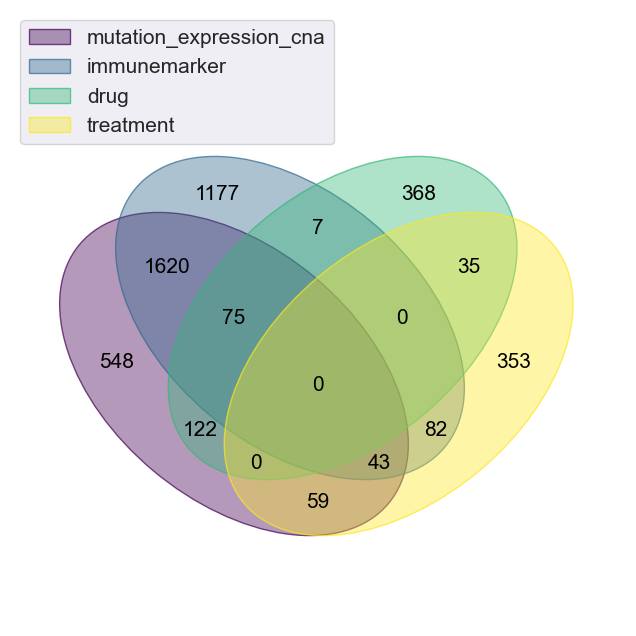

<Figure size 1500x1500 with 0 Axes>

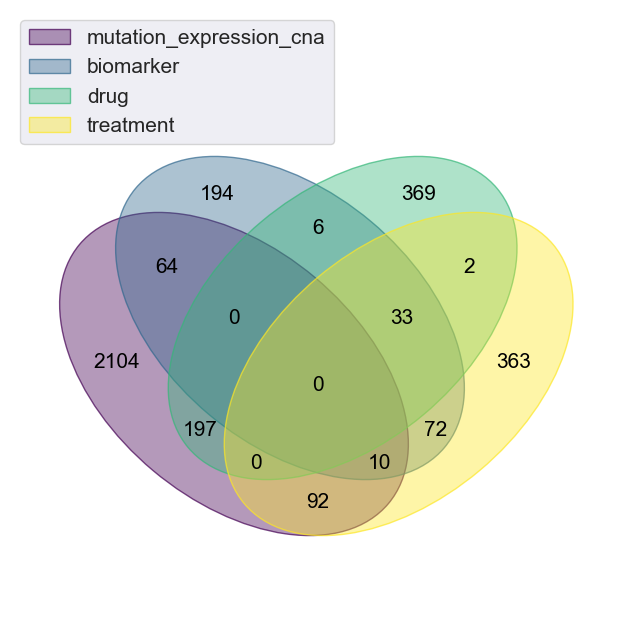

<Figure size 1500x1500 with 0 Axes>

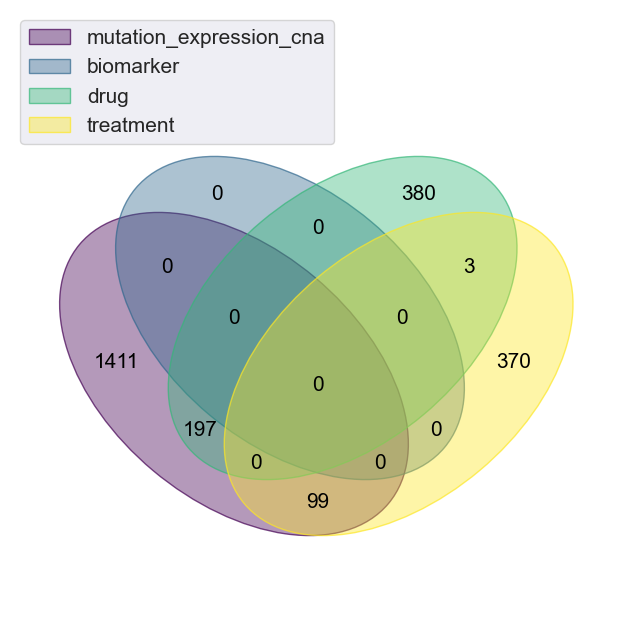

<Figure size 1500x1500 with 0 Axes>

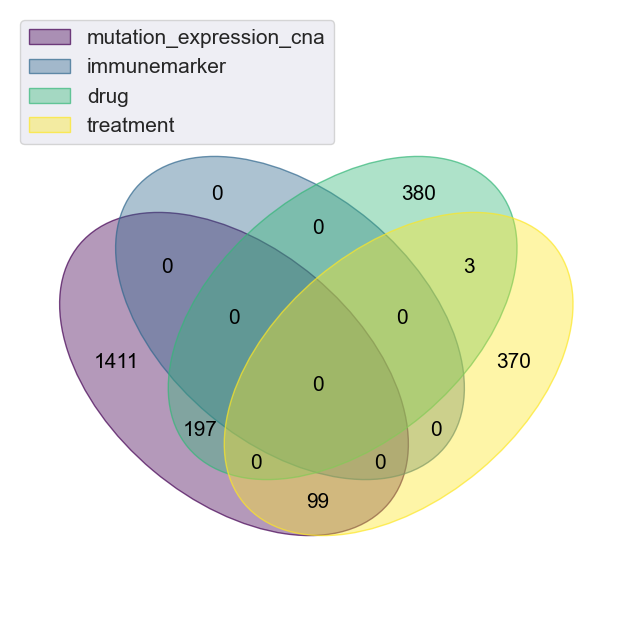

In [76]:
fig_x, fig_y, fs = 15, 15, 15
df = pd.read_csv('DR_v6.2.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'immunemarker', 'drug', 'treatment'))
plt.figure(figsize=(fig_x, fig_y))
venn(data_subset_dict, fontsize=fs, legend_loc="upper left")
plt.savefig('Venn4_dr6.0_immune.png', dpi=800)

df = pd.read_csv('DR_v6.2.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'biomarker', 'drug', 'treatment'))
plt.figure(figsize=(fig_x, fig_y))
venn(data_subset_dict, fontsize=fs, legend_loc="upper left")
plt.savefig('Venn4_dr6.0_bio.png', dpi=800)

df = pd.read_csv('DR_v3.0.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'biomarker', 'drug', 'treatment'))
plt.figure(figsize=(fig_x, fig_y))
venn(data_subset_dict, fontsize=fs, legend_loc="upper left")
plt.savefig('Venn4_dr3_bio.0.png', dpi=800)

df = pd.read_csv('DR_v3.0.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_dict['immunemarker'] = set()
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'immunemarker', 'drug', 'treatment'))
plt.figure(figsize=(fig_x, fig_y))
venn(data_subset_dict, fontsize=fs, legend_loc="upper left")
plt.savefig('Venn4_dr3_immune.png', dpi=800)

<Figure size 1200x1200 with 0 Axes>

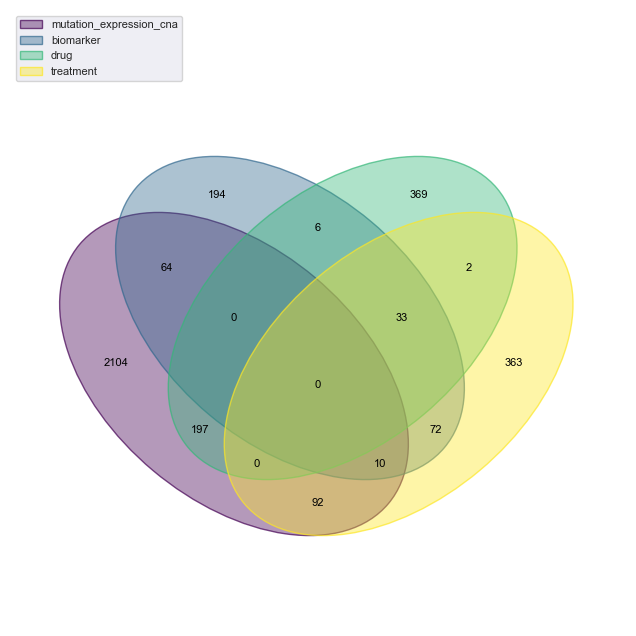

<Figure size 1200x1200 with 0 Axes>

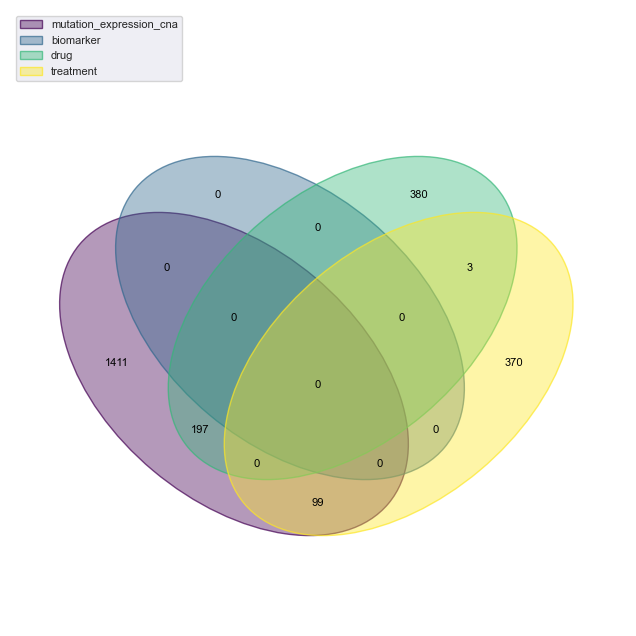

In [74]:
df = pd.read_csv('DR_v3.0.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_dict['biomarker'] = set()
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'biomarker', 'drug', 'treatment'))
plt.figure(figsize=(12,12))
venn(data_subset_dict, fontsize=13, legend_loc="upper left")
plt.savefig('Venn4_dr3_bio.0.png', dpi=800)

df = pd.read_csv('DR_v3.0.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_dict['immunemarker'] = set()
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'immunemarker', 'drug', 'treatment'))
plt.figure(figsize=(12,12))
venn(data_subset_dict, fontsize=13, legend_loc="upper left")
plt.savefig('Venn4_dr3_immune.png', dpi=800)

<Figure size 1500x1500 with 0 Axes>

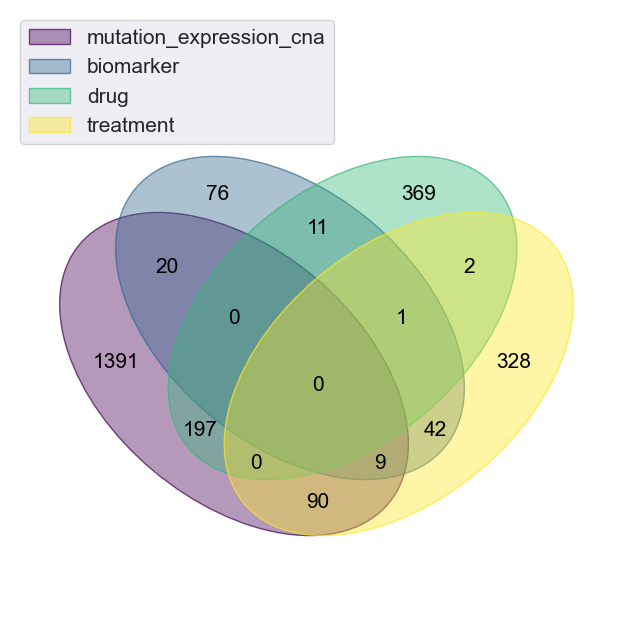

In [6]:
import pandas as pd
df = pd.read_csv('DR_v3.0.csv')
data_dict = df.groupby('molecular_characterisation_type')['model_id'].apply(set).to_dict()
set1, set2, set3 = process_sets(data_dict['mutation']), process_sets(data_dict['expression']), process_sets(data_dict['copy number alteration'])
data_dict['mutation_expression_cna'] = sorted(list(set1 & set2 & set3)) 
data_subset_dict = dict((k, process_sets(data_dict[k])) for k in ('mutation_expression_cna', 'biomarker', 'drug', 'treatment'))
plt.figure(figsize=(15, 15))
venn(data_subset_dict, fontsize=15, legend_loc="upper left")
plt.savefig('Venn4_dr3_bio.0.png', dpi=800)

<Axes: >

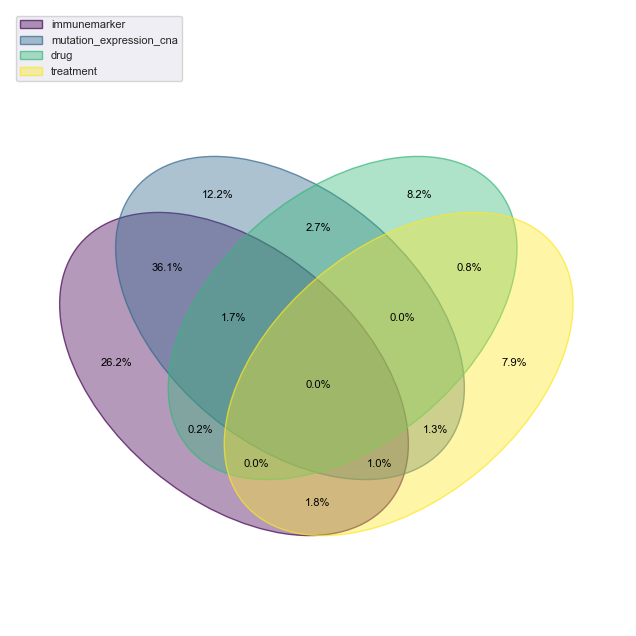

In [53]:
cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
venn(data_subset_dict, fmt="{percentage:.1f}%", fontsize=8, legend_loc="upper left")

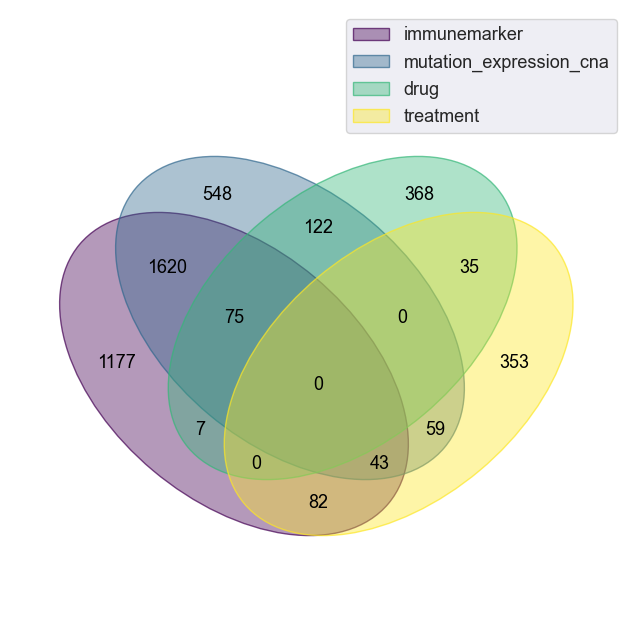

In [57]:
v  = venn(data_subset_dict)

In [ ]:
?venn

In [13]:
subsets = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7]

# Create the Venn diagram
venn5(subsets)
# Display the Venn diagram
plt.show()

AttributeError: 'list' object has no attribute 'keys'

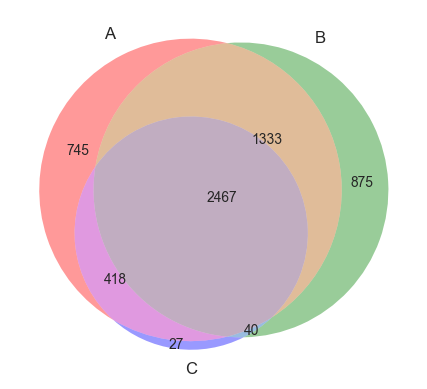

In [60]:
from matplotlib_venn import venn2, venn3
v = venn3([set1, set2, set3])

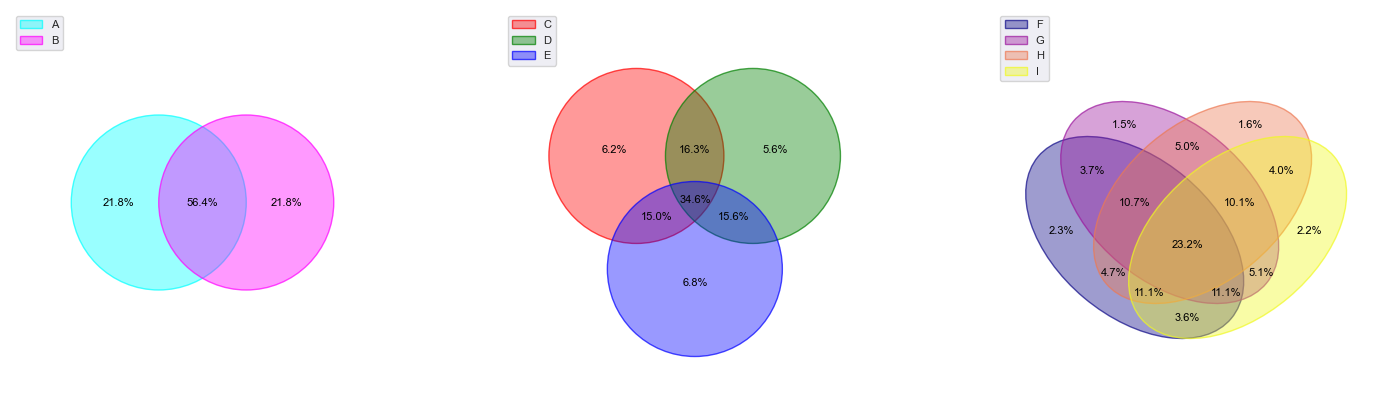

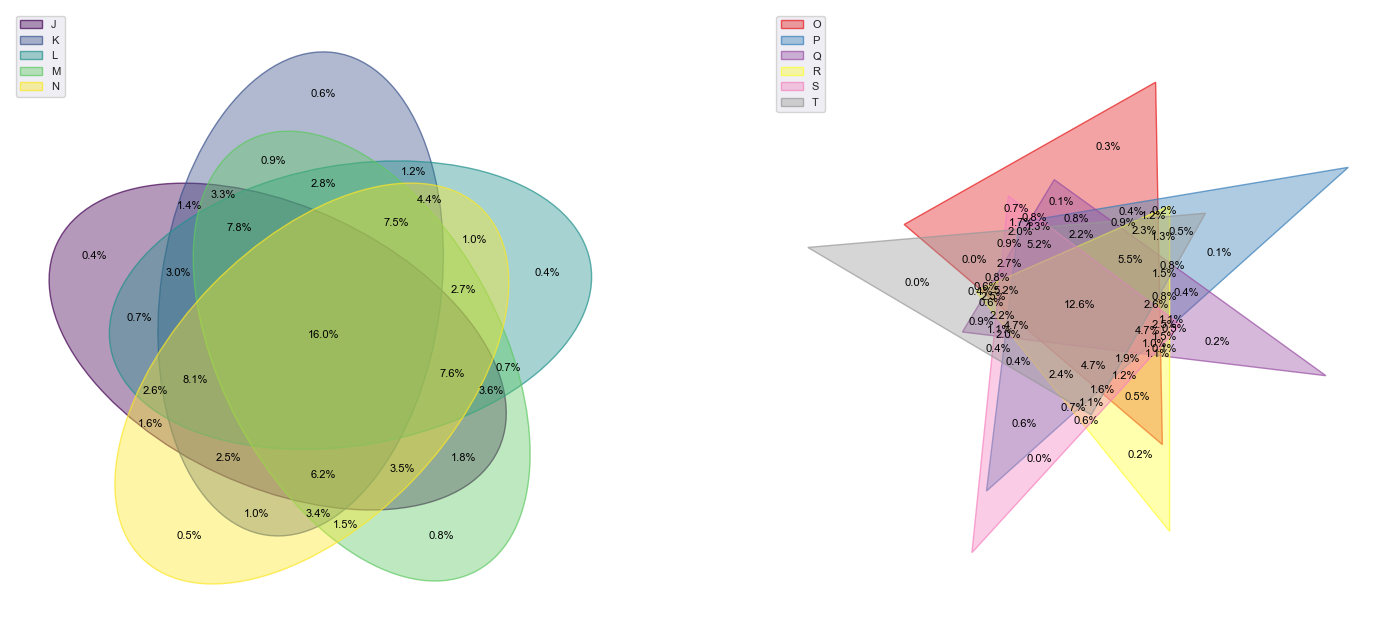

In [11]:
from venn import venn
from matplotlib.pyplot import subplots
from itertools import chain, islice
from string import ascii_uppercase
from numpy.random import choice

_, top_axs = subplots(ncols=3, nrows=1, figsize=(18, 5))
_, bot_axs = subplots(ncols=2, nrows=1, figsize=(18, 8))
cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
letters = iter(ascii_uppercase)

for n_sets, cmap, ax in zip(range(2, 7), cmaps, chain(top_axs, bot_axs)):
    dataset_dict = {
        name: set(choice(1000, 700, replace=False))
        for name in islice(letters, n_sets)
    }
    venn(dataset_dict, fmt="{percentage:.1f}%", cmap=cmap, fontsize=8, legend_loc="upper left", ax=ax)

In [14]:
dataset_dict.keys()

dict_keys(['O', 'P', 'Q', 'R', 'S', 'T'])

In [15]:
dataset_dict['O']

{0,
 4,
 5,
 7,
 8,
 9,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 41,
 42,
 43,
 44,
 45,
 47,
 49,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 66,
 67,
 68,
 69,
 71,
 74,
 75,
 76,
 77,
 79,
 81,
 82,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 111,
 113,
 114,
 115,
 117,
 118,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 138,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 154,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 165,
 167,
 170,
 171,
 173,
 174,
 175,
 178,
 180,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 215,
 216,
 217,
 218,
 219,
 221,
 224,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 240,
 24

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance

# Data
data = {
    'Diagnosis': [
        'Breast cancer', 'Reproductive system', 'Skin', 'Thoracic', 'Endocrine',
        'Eye', 'Connective and Soft tissue', 'Head and Neck', 'Urinary system',
        'Hematopoietic and Lymphoid', 'Nervous system', 'Digestive system'
    ],
    'Models': [
        566, 535, 484, 988, 184, 75, 557, 331, 398, 743, 586, 3091
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Normalize bubble sizes for better visualization
df['Radius'] = np.sqrt(df['Models'] / max(df['Models']) * 1000 / np.pi)

def is_overlapping(x, y, r, circles):
    for (cx, cy, cr) in circles:
        if distance.euclidean((x, y), (cx, cy)) < (r + cr):
            return True
    return False

# Initialize circles list
circles = []
outer_radius = 10

# Generate positions for the circles
for i, row in df.iterrows():
    r = row['Radius']
    placed = False
    while not placed:
        x = np.random.uniform(-outer_radius + r, outer_radius - r)
        y = np.random.uniform(-outer_radius + r, outer_radius - r)
        if (x**2 + y**2 + r**2 <= outer_radius**2) and not is_overlapping(x, y, r, circles):
            circles.append((x, y, r))
            placed = True
            df.at[i, 'x'] = x
            df.at[i, 'y'] = y

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Draw outer circle
outer_circle = plt.Circle((0, 0), outer_radius, color='lightgrey', fill=True)
ax.add_artist(outer_circle)

# Draw small circles
for (x, y, r) in circles:
    circle = plt.Circle((x, y), r, alpha=0.6)
    ax.add_artist(circle)

# Add labels
for i, row in df.iterrows():
    plt.text(row['x'], row['y'], row['Diagnosis'], ha='center', va='center', fontsize=10)

# Set limits and aspect
ax.set_xlim(-outer_radius, outer_radius)
ax.set_ylim(-outer_radius, outer_radius)
ax.set_aspect('equal')

# Remove axes
ax.axis('off')

# Title
plt.title('Diagnosis Models Bubble Plot Inside a Circle')

# Show plot
plt.show()


KeyboardInterrupt: 

In [2]:
import pandas as pd

In [9]:
df = pd.read_csv('total_models_DR_v6.2.csv')
api = pd.read_json('https://www.cancermodels.org/api/search_index?select=external_model_id,histology,cancer_system,data_source')
df = df.merge(api, left_on='model_id', right_on='external_model_id', how='left')

In [16]:
diagnosis_to_cancer_system = {}
for i, j in df[['diagnosis', 'cancer_system']].drop_duplicates().iterrows():
    diagnosis_to_cancer_system[j['diagnosis'].lower()] = j['cancer_system']
diagnosis_to_cancer_system

{'glioblastoma nos': 'Nervous System Cancer',
 'glioblastoma gliosarcoma': 'Nervous System Cancer',
 'pancreatic cancer other': 'Digestive System Cancer',
 'stomach cancer adenocarcinoma (nos)': 'Digestive System Cancer',
 'osteosarcoma': 'Connective and Soft Tissue Cancer',
 'stomach cancer other': 'Digestive System Cancer',
 "ewing's sarcoma": 'Connective and Soft Tissue Cancer',
 'lung cancer carcinoma (nos)': 'Thoracic Cancer',
 'esophageal cancer esophagus adenocarcinoma (nos)': 'Digestive System Cancer',
 'pancreatic cancer adenocarcinoma ductal type': 'Digestive System Cancer',
 'rhabdomyosarcoma alveolar': 'Connective and Soft Tissue Cancer',
 'wilms tumor favorable': 'Urinary System Cancer',
 'rare cancers undifferentiated sarcoma': 'Connective and Soft Tissue Cancer',
 'rare cancers epithelioid sarcoma': 'Connective and Soft Tissue Cancer',
 'rare cancers spindle cell sarcoma': 'Connective and Soft Tissue Cancer',
 'melanoma': 'Nervous System Cancer',
 'lung cancer squamous c

In [8]:
df['on_portal'] = [True if m in api['external_model_id'].to_list() else False for m in df['model_id']]
df[~df['on_portal']]        

,model_id,provider,model_type,publications,age_in_years_at_collection,diagnosis,tumour_type,primary_site,sex,ethnicity,mt,on_portal
377,SIDM01658,CMP,Cell Line,"PMID: 26589293,PMID: 25877200,PMID: 15215163,P...",Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Cell Line,False
414,SIDM00668,CMP,Cell Line,"PMID: 35839778,PMID: 29533902,PMID: 27397505,P...",56,Non-Cancerous,Primary,Haematopoietic and Lymphoid,Female,White,Cell Line,False
807,SIDM00540,CMP,Cell Line,"PMID: 25169794,PMID: 26589293,PMID: 25877200,P...",57,Oral Dysplasia,Primary,Head and Neck,Male,White,Cell Line,False
953,SIDM01075,CMP,Cell Line,NaN,5,Hereditary Spherocytosis,Primary,Haematopoietic and Lymphoid,Male,White,Cell Line,False
1749,SIDM01715,CMP,Cell Line,PMID: 20164919,Not provided,Not provided,Not provided,Not provided,Male,Not provided,Cell Line,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8082,T152,VHIO-CRC,PDX,NaN,67,Colon adenocarcinoma,primary,ileocecal valve,Male,Not Provided,PDX,False
8083,T155,VHIO-CRC,PDX,NaN,65,Colon adenocarcinoma,primary,Sigmoid Flexure,Male,Not Provided,PDX,False
8084,T156,VHIO-CRC,PDX,NaN,49,Colon adenocarcinoma,primary,Right Colon,Male,Not Provided,PDX,False
8085,T157,VHIO-CRC,PDX,NaN,85,Colon adenocarcinoma,primary,Right Colon,Female,Not Provided,PDX,False
